# Tugas Individu 03 - BPNN from Scratch
Yogie Wisesa - 1806200186

## 1. Import library

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

## 2. Import CSV menjadi dataframe menggunakan pandas

In [2]:
df = pd.read_csv("Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


## 3. Verifikasi apakah data ada yang null dan mengecek jumlah class

In [3]:
df['Species'].value_counts()
df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

## 4. Randomize data sebelum di splitting train dan test

In [4]:
# Randomize tiap class
setosa = df.loc[0:50]
versicolor = df.loc[50:100]
virginica = df.loc[100:150]

setosa_shuffled=setosa.sample(frac=1).reset_index(drop=True)
versicolor_shuffled=versicolor.sample(frac=1).reset_index(drop=True)
virginica_shuffled=virginica.sample(frac=1).reset_index(drop=True)

# Gabungkan kembali
df = pd.concat([setosa_shuffled, versicolor_shuffled, virginica_shuffled])

## 5. One hot encoding untuk mengubah Species menjadi array dan mengubah dataframe menjadi np.array()

In [5]:

# One hot encoding
df = pd.get_dummies(df, columns = ['Species']) # buat separate column
df['Species'] = df[df.columns[5:]].apply(lambda x: np.array(x), axis=1)

X = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
X = np.array(X)
print(X[:5])
print(type(X))

Y = np.vstack(df['Species']).astype(np.float)
print(Y[:5])
print(type(Y))

[[5.4 3.4 1.5 0.4]
 [5.2 3.5 1.5 0.2]
 [5.7 4.4 1.5 0.4]
 [5.1 3.7 1.5 0.4]
 [4.7 3.2 1.3 0.2]]
<class 'numpy.ndarray'>
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
<class 'numpy.ndarray'>


<ipython-input-5-3cbe26e73861>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.vstack(df['Species']).astype(np.float)


## 6. Splitting data dengan rasio 70:30

In [6]:
# Split training data sesuai requirement
X_train = X[np.r_[0:35, 50:85, 100:135]]
Y_train = Y[np.r_[0:35, 50:85, 100:135]]
                   
X_test = X[np.r_[35:50, 85:100, 135:150]]
Y_test = Y[np.r_[35:50, 85:100, 135:150]]

## 7. Fungsi pembuatan Neural Network

Fungsi ini yang nantinya akan menjadi neural network dan dimasukkan parameter berupa epoch, jumlah node, training data, dan learning rate.\
Fungsi ini akan mengeluarkan output berupa Recognition Rate yang akan ditampilkan setiap 20 epoch dan akan mereturn weight untuk digunakan pada fungsi propagation

In [7]:
def NeuralNetwork(X_train, Y_train, X_val=None, Y_val=None, epochs=10, nodes=[], lr=0.15):
    hidden_layers = len(nodes) - 1
    weights = InitializeWeights(nodes)

    for epoch in range(1, epochs+1):
        weights = Train(X_train, Y_train, lr, weights)

        if(epoch % 20 == 0):
            print("Epoch {}".format(epoch))
            print("Training Recognition Rate:{}".format(Recognition(X_train, Y_train, weights)))
            if X_val.any():
                print("Testing Recognition Rate:{}".format(Recognition(X_test, Y_test, weights)))
            
    return weights

## 8. Fungsi untuk meng-generate weight random dengan nilai antara -0.5 hingga 0.5

In [8]:
def InitializeWeights(nodes):
    layers, weights = len(nodes), []
    
    for i in range(1, layers):
        w = [[np.random.uniform(-0.5, 0.5) for k in range(nodes[i-1] + 1)]
              for j in range(nodes[i])]
        weights.append(np.matrix(w))
    
    return weights

## 9. Fungsi forward propagation yang akan digunakan untuk melakukan training kepada weight
pada fungsi ini setiap layer akan menerima input dan output. output didapat dari dot product atnara input dan weight. kemudian output tersebut akan dijadikan sebagai input layer selanjutnya menggunakan fungsi activation

In [9]:
def ForwardPropagation(x, weights, layers):
    activations, layer_input = [x], x
    for j in range(layers):
        activation = Sigmoid(np.dot(layer_input, weights[j].T))
        activations.append(activation)
        layer_input = np.append(1, activation)
    
    return activations

## 10. Fungsi back propagation 
Back propagation akan melakukan pengecekan error pada output layer terakhir. pengecekan akan dilakukan secara mundur melewati layer dan mengkoreksinya dengan mengganti weight. 

In [10]:
def BackPropagation(y, activations, weights, layers):
    outputFinal = activations[-1]
    error = np.matrix(y - outputFinal) # Error pada output
    
    for j in range(layers, 0, -1):
        currActivation = activations[j]
        
        if(j > 1):
            #activation
            prevActivation = np.append(1, activations[j-1])
        else:
            #prevActivation
            prevActivation = activations[0]
        
        delta = np.multiply(error, SigmoidDerivative(currActivation))
        weights[j-1] += lr * np.multiply(delta.T, prevActivation)

        w = np.delete(weights[j-1], [0], axis=1) # remove bias
        error = np.dot(delta, w) # menghitung dot product nilai error
    
    return weights

## 10. Fungsi untuk training terhadap weight yang akan digunakan untuk mengoreksi error pada fungsi forward dan backward propagation.

In [11]:
def Train(X, Y, lr, weights):
    layers = len(weights)
    for i in range(len(X)):
        x = X[i]
        y = Y[i]
        x = np.matrix(np.append(1, x)) 
        
        activations = ForwardPropagation(x, weights, layers)
        weights = BackPropagation(y, activations, weights, layers)

    return weights

## 11. Fungsi Sigmoid untuk fungsi activation

In [12]:
def Sigmoid(x):
    return 1 / (1 + np.exp(-x))

def SigmoidDerivative(x):
    return np.multiply(x, 1-x)

## 12. Fungsi untuk melakukan prediksi dengan mempertimbangkan output dari forward propagation dan dioutput dengan one hot encoding

In [13]:
def Predict(item, weights):
    layers = len(weights)
    item = np.append(1, item)
    
    activations = ForwardPropagation(item, weights, layers)
    
    outputFinal = activations[-1].A1
    index = FindMaxActivation(outputFinal)

    y = [0 for i in range(len(outputFinal))]
    y[index] = 1  

    return y 

In [14]:
def FindMaxActivation(output):
    
    m, index = output[0], 0
    for i in range(1, len(output)):
        if(output[i] > m):
            m, index = output[i], i
    
    return index

## 13. Fungsi untuk melakukan recognition menggunakan fungsi prediction sebelumnya. setelah itu hasil prediksi akan dilakukan pengecekan terhadap data aslinya.

In [15]:
def Recognition(X, Y, weights):
   
    correct = 0

    for i in range(len(X)):
        x, y = X[i], list(Y[i])
        guess = Predict(x, weights)

        if(y == guess):  # pengecekan apakah rekognisi benar atau tidak
           
            correct += 1

    return correct / len(X)

## 14. Melakukan prediksi dan menampilkan ratenya dengan menggunan beberapa learning rate

### A. Default parameter dengan learning rate = 0.15 dan epoch = 100

In [16]:
f = len(X[0]) # jumlah feature pada data
o = len(Y[0]) # jumlah class pada data

layers = [f, 5, 10, o] # jumlah node pada layer
lr, epochs = 0.15, 100

weights = NeuralNetwork(X_train, Y_train, X_test, Y_test, epochs=100, nodes=layers, lr=0.15)

hasilTrain1 = Recognition(X_train, Y_train, weights)
hasilTest1 = Recognition(X_test, Y_test, weights)

Epoch 20
Training Recognition Rate:0.3238095238095238
Testing Recognition Rate:0.3333333333333333
Epoch 40
Training Recognition Rate:0.6761904761904762
Testing Recognition Rate:0.6888888888888889
Epoch 60
Training Recognition Rate:0.8095238095238095
Testing Recognition Rate:0.8
Epoch 80
Training Recognition Rate:0.9047619047619048
Testing Recognition Rate:0.8666666666666667
Epoch 100
Training Recognition Rate:0.8095238095238095
Testing Recognition Rate:0.8


### B. Menggunakan learning rate = 0.25

In [17]:
lr = 0.25

weights = NeuralNetwork(X_train, Y_train, X_test, Y_test, epochs=epochs, nodes=layers, lr=lr);

hasilTrain2 = Recognition(X_train, Y_train, weights)
hasilTest2 = Recognition(X_test, Y_test, weights)

Epoch 20
Training Recognition Rate:0.3238095238095238
Testing Recognition Rate:0.3333333333333333
Epoch 40
Training Recognition Rate:0.6857142857142857
Testing Recognition Rate:0.6888888888888889
Epoch 60
Training Recognition Rate:0.7238095238095238
Testing Recognition Rate:0.7111111111111111
Epoch 80
Training Recognition Rate:0.9238095238095239
Testing Recognition Rate:0.8888888888888888
Epoch 100
Training Recognition Rate:0.9333333333333333
Testing Recognition Rate:0.9333333333333333


### C. Menggunakan learning rate = 0.5

In [18]:
lr = 0.5

weights = NeuralNetwork(X_train, Y_train, X_test, Y_test, epochs=epochs, nodes=layers, lr=lr);

hasilTrain3 = Recognition(X_train, Y_train, weights)
hasilTest3 = Recognition(X_test, Y_test, weights)

Epoch 20
Training Recognition Rate:0.3238095238095238
Testing Recognition Rate:0.3333333333333333
Epoch 40
Training Recognition Rate:0.7714285714285715
Testing Recognition Rate:0.7333333333333333
Epoch 60
Training Recognition Rate:0.8095238095238095
Testing Recognition Rate:0.7555555555555555
Epoch 80
Training Recognition Rate:0.8952380952380953
Testing Recognition Rate:0.8222222222222222
Epoch 100
Training Recognition Rate:0.7714285714285715
Testing Recognition Rate:0.7333333333333333


### D. Menggunakan hyperparameter learning rate = 0.75

In [19]:
lr = 0.75

weights = NeuralNetwork(X_train, Y_train, X_test, Y_test, epochs=epochs, nodes=layers, lr=lr);

hasilTrain4 = Recognition(X_train, Y_train, weights)
hasilTest4 = Recognition(X_test, Y_test, weights)

Epoch 20
Training Recognition Rate:0.6666666666666666
Testing Recognition Rate:0.6444444444444445
Epoch 40
Training Recognition Rate:0.6666666666666666
Testing Recognition Rate:0.6444444444444445
Epoch 60
Training Recognition Rate:0.6666666666666666
Testing Recognition Rate:0.6444444444444445
Epoch 80
Training Recognition Rate:0.6666666666666666
Testing Recognition Rate:0.6444444444444445
Epoch 100
Training Recognition Rate:0.6666666666666666
Testing Recognition Rate:0.6444444444444445


## 15. Hasil

In [20]:
tabelIn = np.array([[hasilTrain1,hasilTest1],[hasilTrain2,hasilTest2],[hasilTrain3,hasilTest3],[hasilTrain4,hasilTest4]])

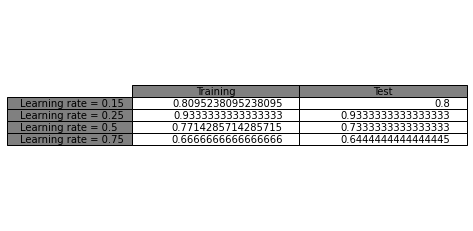

In [21]:
fig, ax =plt.subplots(1,1)
column_labels=["Training", "Test"]
df=pd.DataFrame(tabelIn,columns=column_labels)
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values,
        colLabels=df.columns,
        rowLabels=['Learning rate = 0.15', 'Learning rate = 0.25', 'Learning rate = 0.5', 'Learning rate = 0.75'],
        rowColours =["grey"] * 4,  
        colColours =["grey"] * 2,
        loc="center")
plt.show()

##### Referensi: 
###### https://www.kaggle.com/antmarakis/another-neural-network-from-scratch
###### https://stackoverflow.com/questions/22071987/generate-random-array-of-floats-between-a-range